<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/burgers_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Burgers equation:
## Problem setup

We will solve a Burgers' equation:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [-1, 1], \quad t \in [0, 1]
$$

with the Dirichlet boundary conditions and initial conditions:

$$
u(-1, t) = u(1, t) = 0, \quad u(x, 0) = -\sin(\pi x).
$$

The reference solution is \href{#}{here}.


## Implementation

In [19]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [20]:
# Step 1: Define the Burgers' PDE components
def burgers_pde_residual(model, x, t, nu):
    """
    Compute the PDE residual for Burgers' equation:
    ∂u/∂t + u∂u/∂x - ν∂²u/∂x² = 0
    """
    x.requires_grad = True
    t.requires_grad = True
    u = model(torch.cat((x, t), dim=1))

    # Gradients w.r.t. x and t
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second-order derivative w.r.t. x
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual: ∂u/∂t + u∂u/∂x - ν∂²u/∂x²
    residual = u_t + u * u_x - nu * u_xx
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for Burgers' equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (x, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: u(x, t)
        )

    def forward(self, x):
        return self.hidden_layers(x)

# Step 3: Define the loss function
def compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = burgers_pde_residual(model, x_interior, t_interior, nu)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss: u(-1, t) = 0 and u(1, t) = 0
    u_boundary_left = model(torch.cat((x_boundary[0], t_boundary), dim=1))
    u_boundary_right = model(torch.cat((x_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean(u_boundary_left**2) + torch.mean(u_boundary_right**2)

    # Initial condition loss: u(x, 0) = -sin(πx)
    u_initial_pred = model(torch.cat((x_initial, t_initial), dim=1))
    ic_loss = torch.mean((u_initial_pred - u_initial)**2)

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs, tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)


In [14]:
# Step 5: Generate training data
# Domain: x ∈ [-1, 1], t ∈ [0, 1]
nu = 0.01 / np.pi  # Viscosity
x = torch.linspace(-1, 1, 100).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)

In [18]:
# Interior points
x_interior = x.repeat(100, 1)
t_interior = t.repeat_interleave(100, dim=0)
t_interior

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [21]:
# Step 5: Generate training data
# Domain: x ∈ [-1, 1], t ∈ [0, 1]
nu = 0.01 / np.pi  # Viscosity
x = torch.linspace(-1, 1, 100).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)

# Interior points
x_interior = x.repeat(100, 1)
t_interior = t.repeat_interleave(100, dim=0)

# Boundary points
x_boundary = [torch.full_like(t, -1), torch.full_like(t, 1)]
t_boundary = t

# Initial points
x_initial = x
t_initial = torch.zeros_like(x)
u_initial = -torch.sin(np.pi * x)

# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu)

Adam Epoch 0, Loss: 0.4533082842826843
Adam Epoch 100, Loss: 0.15865546464920044
Adam Epoch 200, Loss: 0.13837876915931702
Adam Epoch 300, Loss: 0.11294396221637726
Adam Epoch 400, Loss: 0.10157394409179688
Adam Epoch 500, Loss: 0.09577948600053787
Adam Epoch 600, Loss: 0.09207518398761749
Adam Epoch 700, Loss: 0.0885097086429596
Adam Epoch 800, Loss: 0.08678475022315979
Adam Epoch 900, Loss: 0.08422677218914032
Starting LBFGS optimization...


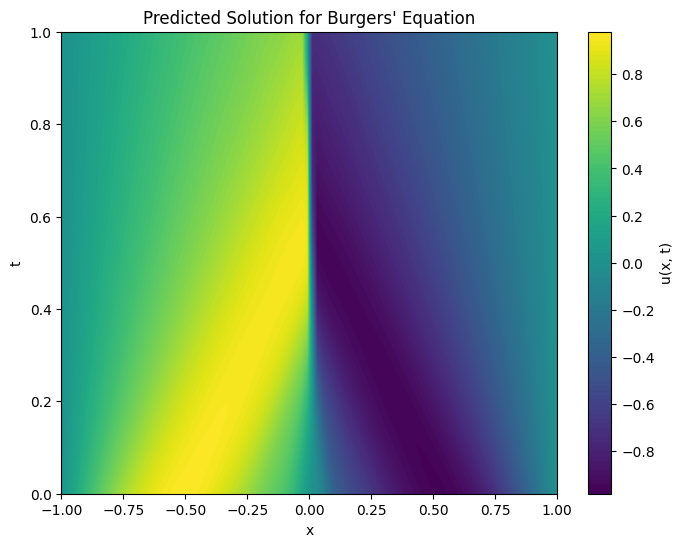

In [24]:
# Step 7: Prediction and Visualization
# Create a grid for prediction
x_pred = torch.linspace(-1, 1, 100).view(-1, 1)
t_pred = torch.linspace(0, 1, 100).view(-1, 1)
x_grid, t_grid = torch.meshgrid(x_pred.squeeze(), t_pred.squeeze(), indexing='ij')
x_flat = x_grid.flatten().view(-1, 1)
t_flat = t_grid.flatten().view(-1, 1)

# Predict using the trained model
u_pred = model(torch.cat((x_flat, t_flat), dim=1)).detach().numpy()
u_pred = u_pred.reshape(100, 100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid.numpy(), t_grid.numpy(), u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Solution for Burgers\' Equation')
plt.show()

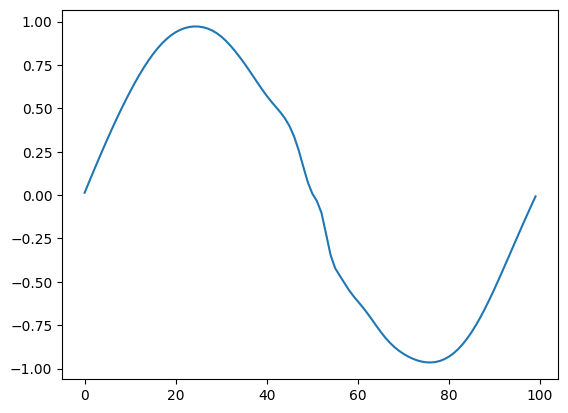

In [25]:
plt.plot(u_pred[:,0])

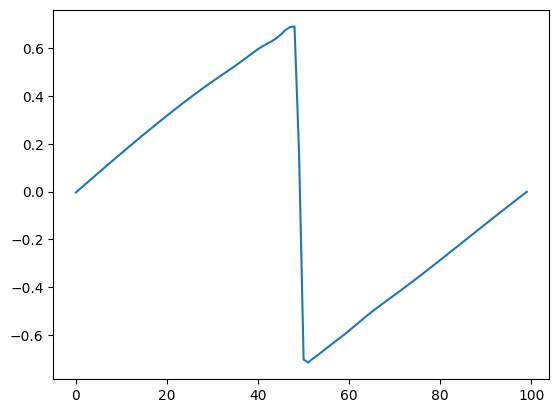

In [27]:
plt.plot(u_pred[:,-1])

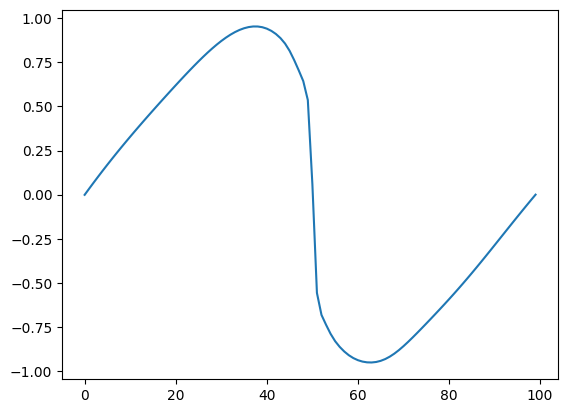

In [28]:
plt.plot(u_pred[:,30])